<a href="https://colab.research.google.com/github/gwal0/TEST/blob/main/1D_Consolidation_Deepxde_0607_TEST_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

L-BFGS 호환 시도 - 성공함, 근데 시료 깊이랑 배수거리에 오류가 있는 걸로 추정함, 0607 버젼에서 수정 예정

In [1]:
### Cell-1
import os
os.environ["DDE_BACKEND"] = "tensorflow"

### Cell-2
!pip install deepxde tensorflow matplotlib --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import deepxde as dde
import tensorflow as tf
print("Eager mode:", tf.executing_eagerly())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.7 MB/s eta 0:00:00


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Eager mode: True


In [2]:
### Cell-3
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab Notebooks/INPUT/CT-1.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')
t_exp = df["time"].values.reshape(-1, 1)
U_exp = df["u_bar"].values.reshape(-1, 1)
df.head()

Mounted at /content/drive


,time,s,u_bar
0,0.00,0.000,0.000000
1,0.25,0.001,0.007576
2,0.50,0.004,0.030303
3,1.00,0.018,0.136364
4,2.00,0.031,0.234848


In [14]:
### Cell-4
# 학습할 압밀계수 변수
c_v = tf.Variable(0.1, trainable=True, dtype=tf.float32, name="c_v") #단위 # cm2/min

# 1차원 압밀 PDE
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    du_zz = dde.grad.hessian(u, x, i=0, j=0)
    return du_t - c_v * du_zz


### Cell-5
# --- User-adjustable initial condition ---
u_0 = 1.0  # 초기 과잉간극수압 (예: 0, 1, 또는 다른 값으로 조정 가능)

# 공간 도메인 (시료 길이 2cm, 양면배수)
H = 2.0  # 시료 두께 [cm]
d = H/2  # 배수거리 [cm]
geom = dde.geometry.Interval(0, H)
timedomain = dde.geometry.TimeDomain(0, 1440.0)  # [min]
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# (추가) AutoGraph 경고 방지를 위한 명시적 함수 정의
@tf.autograph.experimental.do_not_convert
def initial_func(x):
    return u_0 * tf.sin(np.pi * x[:, 0:1] / H)
@tf.autograph.experimental.do_not_convert
def on_initial(x, on):
    return on
@tf.autograph.experimental.do_not_convert
def bc_func(x):
    return 0.0
@tf.autograph.experimental.do_not_convert
def on_boundary_func(x, on):
    return on

# 초기조건: u(z, 0) = u_0 sin(pi z / H)
ic = dde.icbc.IC(geomtime, initial_func, on_initial)

# 경계조건: u(0,t) = u(H,t) = 0 (양면 배수)
bc = dde.icbc.DirichletBC(geomtime, bc_func, on_boundary_func)


### Cell-6
# ✅ PINN 예측 → U_bar 계산, 벡터화된 compute_U_bar_PINN (L-BFGS와 호환)
def compute_U_bar_PINN(model, t_tensor, H, u_0=u_0, num_points=100):
    # z 축 균일 분포 샘플링
    z = tf.linspace(0.0, H, num_points)     # [0,H]
    dz = d / (num_points - 1)               # 적분에 사용할 공간 간격

    # t_exp 길이만큼 반복 확장
    t = tf.reshape(t_tensor, [-1, 1])  # (N, 1)
    z_grid = tf.reshape(z, [1, -1])    # (1, Z)
    z_grid = tf.tile(z_grid, [tf.shape(t)[0], 1])  # (N, Z)
    t_grid = tf.tile(t, [1, num_points])           # (N, Z)

    # 입력 쌍 (z, t) → (N * Z, 2)
    input_tensor = tf.stack([tf.reshape(z_grid, [-1]),
                             tf.reshape(t_grid, [-1])], axis=1)

    # 모델 예측
    u_pred = model.net(input_tensor, training=True)  # (N * Z, 1)
    u_pred = tf.reshape(u_pred, [-1, num_points])    # (N, Z)

    # 평균 압밀도 계산
    integral = tf.reduce_sum(u_pred, axis=1, keepdims=True) * dz
    U_bar = 1.0 - (integral / (u_0 * H))
    return U_bar  # shape: (N, 1)


### Cell-7
# ✅ 실험 데이터 손실 구성
def custom_data_loss(model, t_exp, U_exp, H):
    t_tensor = tf.convert_to_tensor(t_exp, dtype=tf.float32)
    U_tensor = tf.convert_to_tensor(U_exp, dtype=tf.float32)
    U_pred = compute_U_bar_PINN(model, t_tensor, H)
    return tf.reduce_mean(tf.square(U_pred - U_tensor))  # → L_data

# ✅ 사용자 정의 TimePDE 클래스
class CustomTimePDE(dde.data.TimePDE):
    def losses(self, targets, outputs, loss_fn, inputs, model, aux=None):
        # 내부 PDE/BC/IC 손실
        losses = super().losses(targets, outputs, loss_fn, inputs, model, aux)

        # 실험 손실 직접 추가 (추가만 하고 loss 리스트에는 MSE 적용 X)
        losses.append(custom_data_loss(model, t_exp, U_exp, H))  # → L_data 강제포함
        return losses


### Cell-8 삭제

Compiling model...
'compile' took 0.005450 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.17e-02, 1.60e+00, 3.57e-01, 2.90e-01]    [1.17e-02, 1.60e+00, 3.57e-01, 2.90e-01]    []  
1000      [1.57e-03, 5.99e-03, 1.06e-03, 4.00e-02]    [1.57e-03, 5.99e-03, 1.06e-03, 4.00e-02]    []  
2000      [5.08e-04, 4.78e-03, 5.25e-04, 3.82e-02]    [5.08e-04, 4.78e-03, 5.25e-04, 3.82e-02]    []  
3000      [2.31e-04, 5.27e-03, 4.56e-04, 3.66e-02]    [2.31e-04, 5.27e-03, 4.56e-04, 3.66e-02]    []  
4000      [1.53e-04, 2.86e-03, 5.55e-04, 3.36e-02]    [1.53e-04, 2.86e-03, 5.55e-04, 3.36e-02]    []  
5000      [1.04e-04, 1.82e-04, 5.84e-04, 3.04e-02]    [1.04e-04, 1.82e-04, 5.84e-04, 3.04e-02]    []  
6000      [7.20e-05, 1.23e-04, 5.18e-04, 3.01e-02]    [7.20e-05, 1.23e-04, 5.18e-04, 3.01e-02]    []  
7000      [5.01e-05, 2.68e-05, 5.19e-04, 3.00e-02]    [5.01e-05, 2.68e-05, 5.19e-04, 3.00e-02]    []  
8

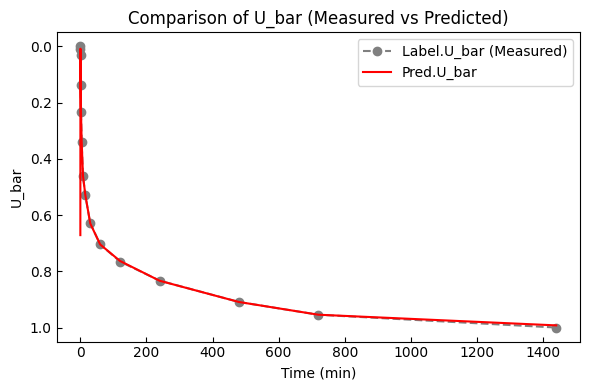

📉 L_data (after Adam): 0.030050095
📌 예측 압밀계수 c_v (after Adam): 0.0014410437 cm²/min
📌 (단위 변환) c_v: 2.4017394e-05 cm²/sec
    Time (min)  U_bar (Measured)  Pred.U_bar
0         0.00            0.0000      0.6713
1         0.25            0.0076      0.0082
2         0.50            0.0303      0.0311
3         1.00            0.1364      0.1357
4         2.00            0.2348      0.2365
5         4.00            0.3409      0.3391
6         8.00            0.4621      0.4602
7        15.00            0.5303      0.5281
8        30.00            0.6288      0.6300
9        60.00            0.7045      0.7045
10      120.00            0.7652      0.7633
11      240.00            0.8333      0.8337
12      480.00            0.9091      0.9092
13      720.00            0.9545      0.9544
14     1440.00            1.0000      0.9924
Compiling model...
'compile' took 0.007068 s

Training model...

Step      Train loss                                  Test loss                               

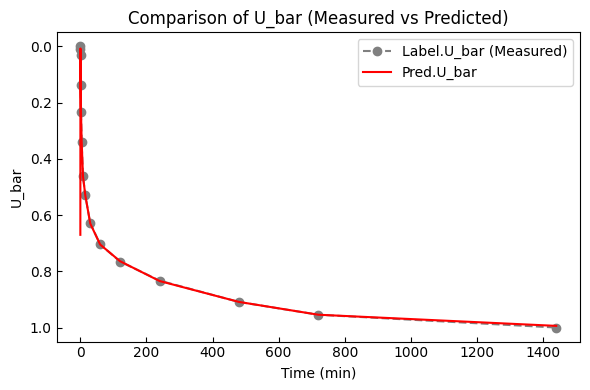

    Time (min)  U_bar (Measured)  Pred.U_bar
0         0.00            0.0000      0.6702
1         0.25            0.0076      0.0075
2         0.50            0.0303      0.0307
3         1.00            0.1364      0.1350
4         2.00            0.2348      0.2363
5         4.00            0.3409      0.3396
6         8.00            0.4621      0.4620
7        15.00            0.5303      0.5299
8        30.00            0.6288      0.6302
9        60.00            0.7045      0.7048
10      120.00            0.7652      0.7641
11      240.00            0.8333      0.8347
12      480.00            0.9091      0.9089
13      720.00            0.9545      0.9545
14     1440.00            1.0000      0.9941
📉 L_data (after L-BFGS): 0.029951723
📌 예측 압밀계수 c_v: 0.0012906579 cm²/min
📌 (단위 변환) c_v: 2.1510965e-05 cm²/sec


In [15]:
### Cell-9
# ✅ 데이터 구성
data_adam = CustomTimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2000,
    num_boundary=100,
    num_initial=100,
)

net = dde.nn.FNN([2] + [50]*3 + [1], "tanh", "Glorot normal")
model = dde.Model(data_adam, net)

model.compile("adam",
              lr=1e-3,
              loss=["MSE", "MSE", "MSE"],
              external_trainable_variables=[c_v])

# ✅ 학습 (Adam)
model.train(iterations=10000)

# 📉 그래프 시각화 (Adam) #
t_tensor = tf.convert_to_tensor(t_exp, dtype=tf.float32)
U_pred = compute_U_bar_PINN(model, t_tensor, H).numpy()

plt.figure(figsize=(6, 4))
plt.plot(t_exp, U_exp, "o--", color="gray", label="Label.U_bar (Measured)")
plt.plot(t_exp, U_pred, "r-", label="Pred.U_bar")
plt.xlabel("Time (min)")
plt.ylabel("U_bar")
plt.title("Comparison of U_bar (Measured vs Predicted)")
plt.legend()
plt.grid(False)
plt.tick_params(direction="in")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ✅ Adam 종료 후 L_data 오차 확인
loss_adam = custom_data_loss(model, t_exp, U_exp, H).numpy()
print("📉 L_data (after Adam):", loss_adam)
print("📌 예측 압밀계수 c_v (after Adam):", c_v.numpy(), "cm²/min")
print("📌 (단위 변환) c_v:", c_v.numpy() / 60, "cm²/sec")

# DataFrame으로 정리
df_compare = pd.DataFrame({
    "Time (min)": t_exp.flatten(),
    "U_bar (Measured)": U_exp.flatten(),
    "Pred.U_bar": U_pred.flatten()
})

pd.set_option("display.precision", 4)
pd.set_option("display.max_rows", None)

print(df_compare)

# ✅ L-BFGS: 동일 모델로 재컴파일 (L_data 유지)
model.compile("L-BFGS",
              loss=["MSE", "MSE", "MSE"],
              external_trainable_variables=[c_v])
model.train()

# 📉 그래프 시각화 (L-BFGS) #
t_tensor = tf.convert_to_tensor(t_exp, dtype=tf.float32)
U_pred = compute_U_bar_PINN(model, t_tensor, H).numpy()

plt.figure(figsize=(6, 4))
plt.plot(t_exp, U_exp, "o--", color="gray", label="Label.U_bar (Measured)")
plt.plot(t_exp, U_pred, "r-", label="Pred.U_bar")
plt.xlabel("Time (min)")
plt.ylabel("U_bar")
plt.title("Comparison of U_bar (Measured vs Predicted)")
plt.legend()
plt.grid(False)
plt.tick_params(direction="in")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# DataFrame으로 정리
df_compare = pd.DataFrame({
    "Time (min)": t_exp.flatten(),
    "U_bar (Measured)": U_exp.flatten(),
    "Pred.U_bar": U_pred.flatten()
})

pd.set_option("display.precision", 4)
pd.set_option("display.max_rows", None)

print(df_compare)

# ✅ L-BFGS 종료 후 출력
loss_lbfgs = custom_data_loss(model, t_exp, U_exp, H).numpy()
print("📉 L_data (after L-BFGS):", loss_lbfgs)
print("📌 예측 압밀계수 c_v:", c_v.numpy(), "cm²/min")
print("📌 (단위 변환) c_v:", c_v.numpy() / 60, "cm²/sec")

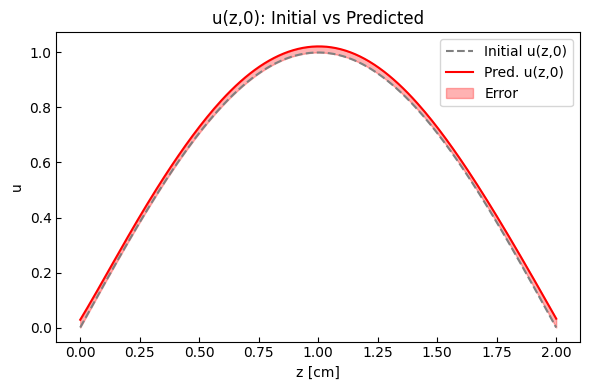

MSE Loss between predicted and true u(z,0): 0.000519


In [16]:
# u(z,0) 비교용
z_vals = np.linspace(0, H, 200).reshape(-1, 1)
t_zero = np.zeros_like(z_vals)
ZT = np.hstack([z_vals, t_zero])
u_pred = model.predict(ZT).flatten()
u_true = u_0 * np.sin(np.pi * z_vals.flatten() / H)

# 차이 계산
u_error = u_pred - u_true

# 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(z_vals, u_true, color="gray", label='Initial u(z,0)', linestyle='--')
plt.plot(z_vals, u_pred, color="red", label='Pred. u(z,0)')
plt.fill_between(z_vals.flatten(), u_true, u_pred, color='red', alpha=0.3, label='Error')
plt.xlabel("z [cm]")
plt.ylabel("u")
plt.title("u(z,0): Initial vs Predicted")
plt.legend()
plt.grid(False)
plt.tick_params(direction="in")
plt.tight_layout()
plt.show()

# MSE Loss 계산
mse_loss = np.mean((u_pred - u_true) ** 2)
print(f"MSE Loss between predicted and true u(z,0): {mse_loss:.6f}")

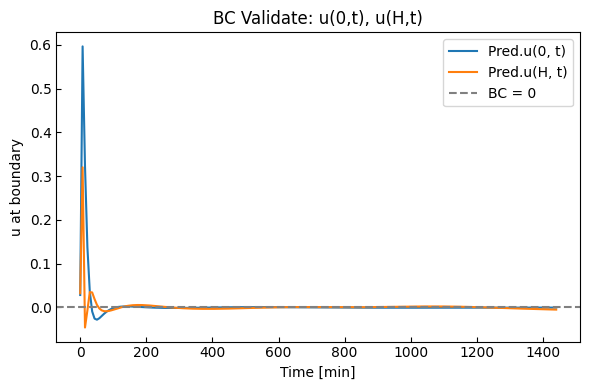

MSE Loss at z=0 (u(0,t)): 0.002422
MSE Loss at z=H (u(H,t)): 0.000549


In [17]:
# 시간 샘플링
t_vals = np.linspace(0, 1440.0, 200).reshape(-1, 1)

# z=0 위치와 z=H 위치에서의 (z, t) 입력 생성
z0 = np.zeros_like(t_vals)
zH = np.ones_like(t_vals) * H

ZT_0 = np.hstack([z0, t_vals])
ZT_H = np.hstack([zH, t_vals])

# 예측
u_pred_0 = model.predict(ZT_0).flatten()
u_pred_H = model.predict(ZT_H).flatten()

# 시각화
plt.figure(figsize=(6, 4))
plt.plot(t_vals, u_pred_0, label='Pred.u(0, t)')
plt.plot(t_vals, u_pred_H, label='Pred.u(H, t)')
plt.axhline(0.0, color='gray', linestyle='--', label='BC = 0')
plt.xlabel("Time [min]")
plt.ylabel("u at boundary")
plt.title("BC Validate: u(0,t), u(H,t)")
plt.legend()
plt.grid(False)
plt.tick_params(direction="in")
plt.tight_layout()
plt.show()

# 경계 조건은 0이므로, true 값은 모두 0
u_true_bc = np.zeros_like(t_vals).flatten()

# MSE 계산
mse_bc_0 = np.mean((u_pred_0 - u_true_bc) ** 2)
mse_bc_H = np.mean((u_pred_H - u_true_bc) ** 2)

print(f"MSE Loss at z=0 (u(0,t)): {mse_bc_0:.6f}")
print(f"MSE Loss at z=H (u(H,t)): {mse_bc_H:.6f}")

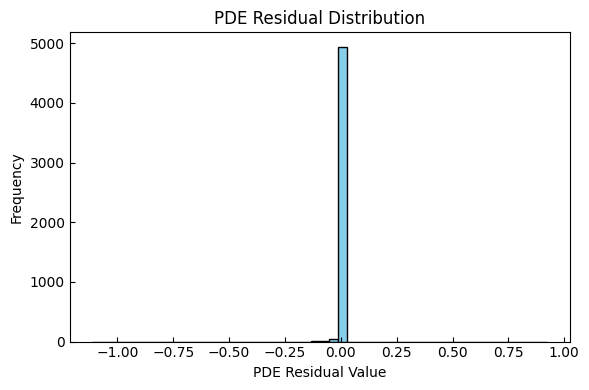

📌 PDE Residual 평균: -0.00086268655
📌 PDE Residual 표준편차: 0.024676248


In [24]:
# 내부 점 샘플링
num_samples = 5000
z_sample = np.random.uniform(0, H, size=(num_samples, 1))
t_sample = np.random.uniform(0, 1440.0, size=(num_samples, 1))
XT_sample = np.hstack([z_sample, t_sample])
XT_tensor = tf.convert_to_tensor(XT_sample, dtype=tf.float32)

# u(z, t) 예측
with tf.GradientTape(persistent=True) as tape2:
    tape2.watch(XT_tensor)
    with tf.GradientTape() as tape1:
        tape1.watch(XT_tensor)
        u = model.net(XT_tensor)
    du = tape1.gradient(u, XT_tensor)  # 1차 도함수
    du_t = du[:, 1:2]                   # 시간 미분
    du_z = du[:, 0:1]                   # 공간 1차 미분

# 공간 2차 도함수
du_zz = tape2.gradient(du_z, XT_tensor)[:, 0:1]

# PDE 잔차 계산
residual = du_t - c_v * du_zz

# 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.hist(residual.numpy().flatten(), bins=50, color='skyblue', edgecolor='black')
plt.xlabel("PDE Residual Value")
plt.ylabel("Frequency")
plt.title("PDE Residual Distribution")
plt.tick_params(direction="in")
plt.tight_layout()
plt.show()

print("📌 PDE Residual 평균:", np.mean(residual.numpy()))
print("📌 PDE Residual 표준편차:", np.std(residual.numpy()))

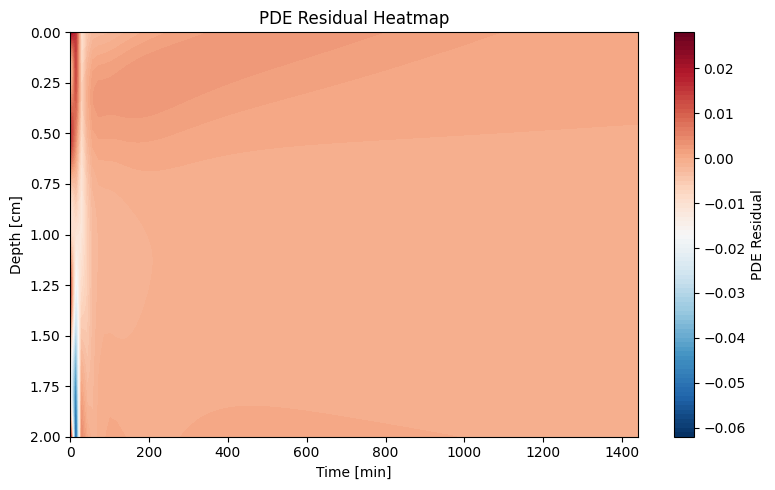

In [8]:
import matplotlib.pyplot as plt

# 그리드 생성
z_vals = np.linspace(0, H, 100)
t_vals = np.linspace(0, 1440, 100)
Z, T = np.meshgrid(z_vals, t_vals)
ZT = np.hstack([Z.flatten()[:, None], T.flatten()[:, None]])
ZT_tensor = tf.convert_to_tensor(ZT, dtype=tf.float32)

# 예측 및 도함수 계산
with tf.GradientTape(persistent=True) as tape2:
    tape2.watch(ZT_tensor)
    with tf.GradientTape() as tape1:
        tape1.watch(ZT_tensor)
        u = model.net(ZT_tensor)
    du = tape1.gradient(u, ZT_tensor)
    du_t = du[:, 1:2]
    du_z = du[:, 0:1]
du_zz = tape2.gradient(du_z, ZT_tensor)[:, 0:1]

residual = du_t - c_v * du_zz
res_grid = residual.numpy().reshape(100, 100)

# 시각화
plt.figure(figsize=(8, 5))
plt.contourf(T, Z, res_grid, levels=100, cmap="RdBu_r")
plt.colorbar(label="PDE Residual")
plt.xlabel("Time [min]")
plt.ylabel("Depth [cm]")
plt.title("PDE Residual Heatmap")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


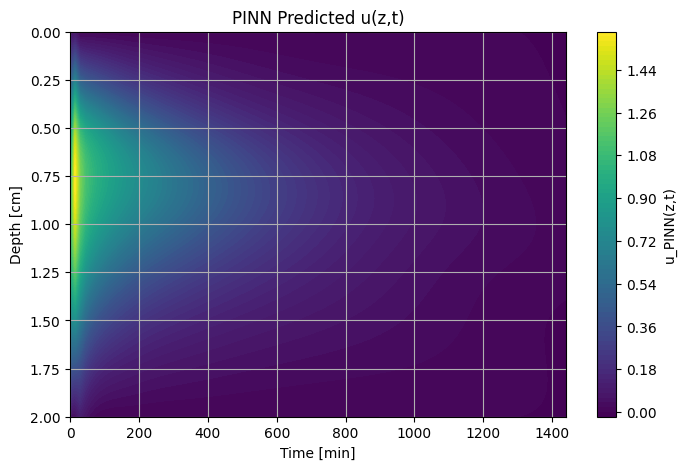

▶ PINN 예측 결과


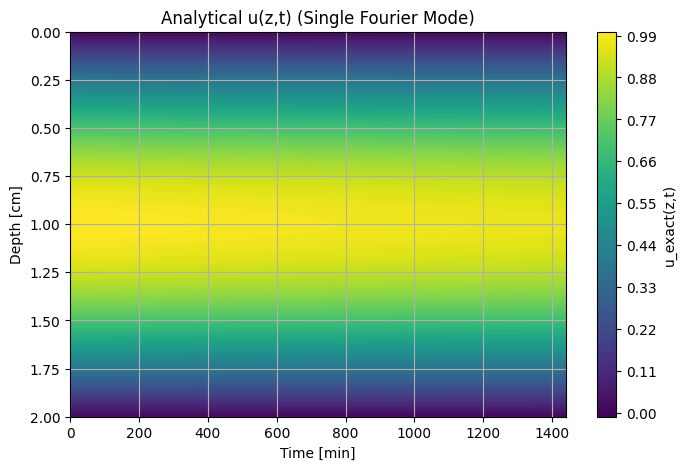

▶ 해석해 (n=1 모드)
▶ PINN vs 해석해 평균제곱오차 (MSE): 2.9369e-01


In [ ]:
### Cell-11
# ✅ 해석해 정의
def exact_solution(x):
    z = x[:, 0:1]
    t = x[:, 1:2]
    return u_0 * tf.sin(np.pi * z / H) * tf.exp((-c_v / 60) * (np.pi / H)**2 * t)

# ✅ PINN vs 해석해 비교용 Heatmap
z_vals = np.linspace(0, H, 100).reshape(-1, 1)
t_vals = np.linspace(0, 1440.0, 100).reshape(-1, 1)
Z, T = np.meshgrid(z_vals.flatten(), t_vals.flatten())
ZT = np.hstack((Z.flatten()[:, None], T.flatten()[:, None]))

# PINN 예측
u_pred = model.predict(ZT).reshape(100, 100)

# 해석해 계산
ZT_tensor = tf.convert_to_tensor(ZT, dtype=tf.float32)
u_exact = exact_solution(ZT_tensor).numpy().reshape(100, 100)

# 🔹 PINN Heatmap
plt.figure(figsize=(8, 5))
plt.contourf(T, Z, u_pred, levels=100, cmap="viridis")
plt.colorbar(label="u_PINN(z,t)")
plt.xlabel("Time [min]")
plt.ylabel("Depth [cm]")
plt.title("PINN Predicted u(z,t)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

print("▶ PINN 예측 결과")

# 🔹 해석해 Heatmap
plt.figure(figsize=(8, 5))
plt.contourf(T, Z, u_exact, levels=100, cmap="viridis")
plt.colorbar(label="u_exact(z,t)")
plt.xlabel("Time [min]")
plt.ylabel("Depth [cm]")
plt.title("Analytical u(z,t) (Single Fourier Mode)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

print("▶ 해석해 (n=1 모드)")

# ✅ PINN vs 해석해 MSE 계산
mse_loss = np.mean((u_pred - u_exact) ** 2)
print(f"▶ PINN vs 해석해 평균제곱오차 (MSE): {mse_loss:.4e}")